## Model creation

In [78]:
import torch
import torch.nn as nn

In [79]:
class Discriminator(nn.Module):
    def __init__(self, channel_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channel_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            
            self._block(features_d, features_d*2, 4, 2 , 1 ),
            self._block(features_d * 2, features_d*4, 4, 2, 1),
            self._block(features_d * 4, features_d*8, 4, 2, 1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )
        
    def _block(self,in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride, bias=False),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, x):
        return self.disc(x)

In [80]:
class demoGenerator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(demoGenerator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            #nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [81]:
class Generator(nn.Module):
    def __init__(self, channel_noise, channel_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(channel_noise, features_g * 16, 4, 1, 0),
            self._block(features_g * 16,features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g * 2, channel_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh()
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            #nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [82]:
def initialise_weights(model):
    for m in model.modules():
        if isinstance(m , (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.2)
    

In [83]:
#checking

N, in_channels, H, W = 8, 3, 64, 64
noise_dim = 100
x = torch.randn(N, in_channels, H , W)
disc = Discriminator(in_channels, 8)
assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
print(disc(x).shape)
gen = demoGenerator(noise_dim, in_channels,  8)
z = torch.randn(N, noise_dim, 1,1)

print(gen(z).shape)

gen = Generator(noise_dim, in_channels, 8)

print(gen(z).shape)
# assert gen(z).shape == (N, 3, 64, 64) , "Generator test failed"

torch.Size([8, 1, 1, 1])
torch.Size([8, 3, 64, 64])
torch.Size([8, 3, 64, 64])


## Testing the model on dataset

In [84]:
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder

In [85]:
# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64

## Testing on Chinese dataset

In [86]:
from PIL import Image
import pandas as pd

df = pd.read_csv('../input/chinese-mnist/chinese_mnist.csv')

df.head()


,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


In [87]:
my_transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
#         transforms.Normalize(
#             [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
#         ),
    ]
)

In [88]:
train_dataset = ImageFolder(root="../input/chinese-mnist/data", transform=my_transforms)

In [95]:
x, _= train_dataset[1030]

x.shape

torch.Size([3, 64, 64])

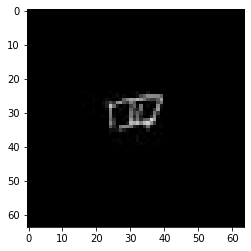

In [96]:
import matplotlib.pyplot as plt

plt.imshow(x.permute(1,2,0))

In [97]:
dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [99]:
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialise_weights(gen)
initialise_weights(disc)

In [105]:
optim_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optim_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

In [103]:
loss_criterion = nn.BCELoss()

In [112]:
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
step = 0

In [113]:
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [ ]:

from torch.utils.tensorboard import SummaryWriter

# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64


dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialise_weights(gen)
initialise_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

Epoch [0/5] Batch 0/118                   Loss D: 38.2812, loss G: 23.2390


In [116]:
# train_one_loop(disc, gen, dataloader, show_image=1)